In [17]:
from smartem.segmentation import segmenter, utils
from skimage import measure, exposure
from smartem.offline.train_mb_error_detector.NNtools import UNet as UNet_offline
from smartem.offline.train_mb_error_detector.tools import get_error_GT

import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyvoi
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp
from tqdm import tqdm
from scipy import ndimage as ndi
import time

# Set variables

In [2]:
mask_data_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
err_data_path = "/storage2/projects/smartEM/em-vis/smartem-data-test-errors.hdf5"
base_dwt = 50
device = torch.device("cuda:2")

model = UNet_offline.UNet(1,2)
em2mb_path = '/home/tommy-local/projects/smartem/SmartEM/pretrained_models/em2mb_best.pth'
errnet_path = '/home/tommy-local/projects/smartem/SmartEM/pretrained_models_errnet/unet_50_2.81e-02.pth'

# Show ERRNet ground truth

In [3]:
Iseg = segmenter.Segmenter(em2mb_path, device=device)
Iseg.set_model(model_class=model)


16.127745151519775
im_fdt: (1640, 1920) uint8 2-140.0-255
im_sdt: (1640, 1920) uint8 7-152.0-253
mask: (1632, 1920) uint8 0-0.0-255
mb_probs: (1632, 1920) uint8 0-30.0-255
mb_probs_sdt: (1632, 1920) uint8 0-13.0-255
labels: (1632, 1920) bool False-0.0-True
e1: (1632, 1920) uint8 0-0.0-255
e2: (1632, 1920) uint8 0-0.0-255


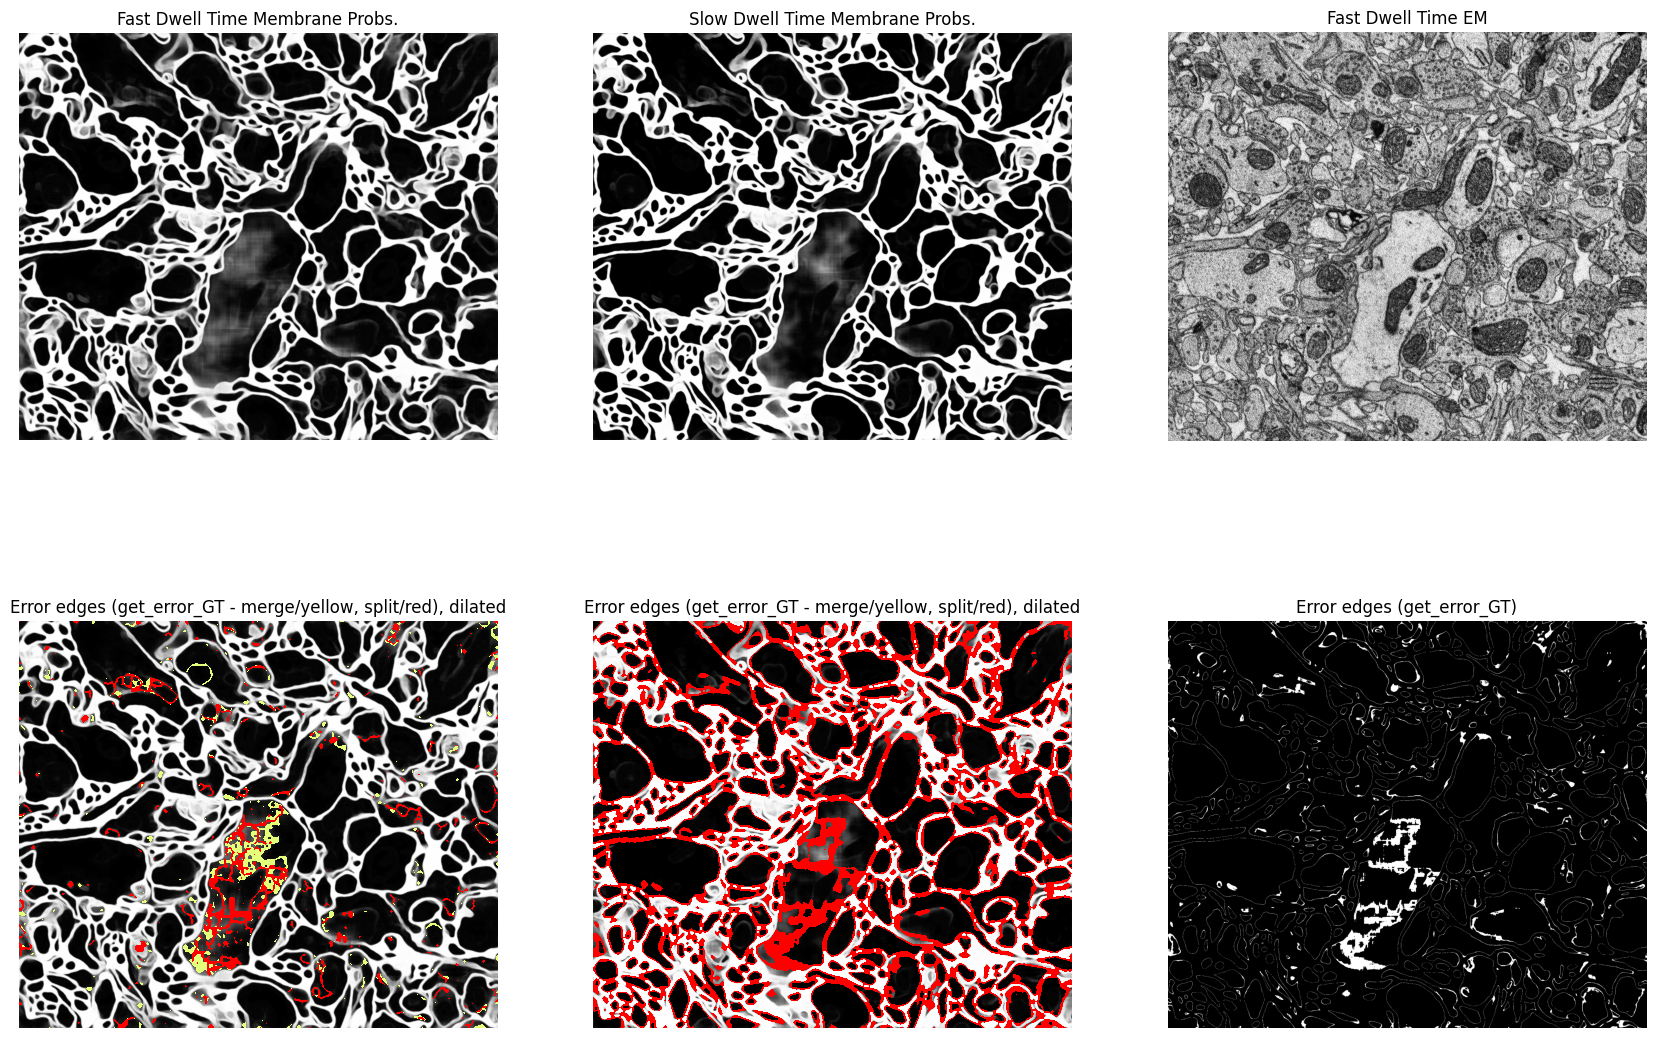

In [19]:
with h5py.File(mask_data_path, 'r') as h5:
    regs=h5.attrs["regs"]
    dwts = h5.attrs["dwts"]
    reg = regs[0]
    max_dwt = np.amax(dwts)
    im,mask=h5[reg+"/"+str(base_dwt)+"/im"],h5[reg+"/"+str(base_dwt)+"/mask"]
    im_sdt = h5[reg+"/"+str(max_dwt)+"/im"]

    # Make predictions
    mask=Iseg.preprocess(mask)
    mask = np.squeeze(mask)
    mask = (mask*255).astype(np.uint8)

    _, mb_probs = Iseg.get_membranes(im, get_probs=True)
    mb_probs = (mb_probs*255).astype(np.uint8)
    mb_probs_certainty = np.abs(77 - mb_probs)
    percentile = np.percentile(mb_probs_certainty.flatten(), 5)

    _, mb_probs_sdt = Iseg.get_membranes(im_sdt, get_probs=True)
    mb_probs_sdt = (mb_probs_sdt*255).astype(np.uint8)

    # Generate error mask
    tic = time.time()
    labels, e1, e2 = get_error_GT(mb_probs, mb_probs_sdt)
    print(time.time()-tic)
    labels = labels.astype(np.uint8)*255
    e1 = ((e1 > 0)*255).astype(np.uint8)
    e2 = ((e2 > 0)*255).astype(np.uint8)

    labels = mb_probs_certainty < percentile
    # e1 = labels
    # e2 = labels

    im = np.array(im)

    print(f"im_fdt: {im.shape} {im.dtype} {np.amin(im)}-{np.median(im)}-{np.amax(im)}")
    print(f"im_sdt: {im_sdt.shape} {im_sdt.dtype} {np.amin(im_sdt)}-{np.median(im_sdt)}-{np.amax(im_sdt)}")
    print(f"mask: {mask.shape} {mask.dtype} {np.amin(mask)}-{np.median(mask)}-{np.amax(mask)}")
    print(f"mb_probs: {mb_probs.shape} {mb_probs.dtype} {np.amin(mb_probs)}-{np.median(mb_probs)}-{np.amax(mb_probs)}")
    print(f"mb_probs_sdt: {mb_probs_sdt.shape} {mb_probs_sdt.dtype} {np.amin(mb_probs_sdt)}-{np.median(mb_probs_sdt)}-{np.amax(mb_probs_sdt)}")
    print(f"labels: {labels.shape} {labels.dtype} {np.amin(labels)}-{np.median(labels)}-{np.amax(labels)}")
    print(f"e1: {e1.shape} {e1.dtype} {np.amin(e1)}-{np.median(e1)}-{np.amax(e1)}")
    print(f"e2: {e2.shape} {e2.dtype} {np.amin(e2)}-{np.median(e2)}-{np.amax(e2)}")



labels_dilated = ndi.binary_dilation(labels, iterations=8)
labels_masked = np.ma.masked_where(labels_dilated == 0, labels_dilated)
e1_dilated = ndi.binary_dilation(e1, iterations=8)
e1_masked = np.ma.masked_where(e1_dilated == 0, e1_dilated)
e2_dilated = ndi.binary_dilation(e2, iterations=8)
e2_masked = np.ma.masked_where(e2_dilated == 0, e2_dilated)

f, axs = plt.subplots(nrows=2, ncols=3)
axs[0,0].imshow(mb_probs, cmap='gray')
axs[0,0].set_title("Fast Dwell Time Membrane Probs.")
axs[1,0].imshow(mb_probs, cmap='gray')
#axs[1,0].imshow(labels_masked, cmap='autumn')
axs[1,0].imshow(e1_masked, cmap='Wistia')
axs[1,0].imshow(e2_masked, cmap='autumn')
axs[1,0].set_title("Error edges (get_error_GT - merge/yellow, split/red), dilated")

axs[0,1].imshow(mb_probs_sdt, cmap='gray')
axs[0,1].set_title("Slow Dwell Time Membrane Probs.")
axs[1,1].imshow(mb_probs_sdt, cmap='gray')
axs[1,1].set_title("Error edges (get_error_GT - merge/yellow, split/red), dilated")
axs[1,1].imshow(labels_masked, cmap='autumn')
#axs[1,1].imshow(e1_masked, cmap='Wistia')
#axs[1,1].imshow(e2_masked, cmap='autumn')

axs[0,2].imshow(im, cmap='gray')
axs[0,2].set_title("Fast Dwell Time EM")
axs[1,2].imshow(labels, cmap='gray')
axs[1,2].set_title("Error edges (get_error_GT)")


for ax in axs.flatten():
    ax.axis("off")

f.set_figheight(14)
f.set_figwidth(21)

# Compute VI vs dwell time

In [3]:
model = model.to(device)
weights = torch.load(errnet_path, map_location=device)
model.load_state_dict(weights)
model.eval()
print()

In [4]:
def get_prediction(im, model):
    # applies network to 2d numpy image
    im = im[np.newaxis, ...] # make 3d
    im = torch.as_tensor(im.copy()).float().contiguous()
    im = im.unsqueeze(0)
    im = im.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = model(im).cpu()
        # binarize the output based on the threshold of 0.5
        if (output >= 0).all() and (output <= 1).all():
            mask = output > 0.5
        else:
            output = torch.sigmoid(output)
            mask = output > 0.5

    mask = mask.squeeze().numpy()[1]
    mask = mask.astype(np.uint8) * 255
    probs = output.squeeze().numpy()[1]

    return mask, probs
    

In [27]:
data_dwts = []
data_hdt_vois = []
data_gt_vois = []

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), disable=True):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        print(f"{np.sum(gt_mask)/np.amax(gt_mask)}/{np.prod(gt_mask.shape)} true rescan pixels")

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        hdt_mask, _ = get_prediction(im, model)

        # all dwts
        for dwt in group.keys():
            im = group[f"{dwt}/im"][()]

            mask, probs = get_prediction(im, model)
            print(f"{np.sum(mask)/np.amax(mask)}/{np.prod(mask.shape)} predicted rescan pixels")

            voi_gt,_,_ = pyvoi.VI(gt_mask.flatten(), mask.flatten())
            voi_hdt,_,_ = pyvoi.VI(hdt_mask.flatten(), mask.flatten())
            data_gt_vois.append(voi_gt.item())
            data_hdt_vois.append(voi_hdt.item())
            data_dwts.append(int(dwt))



data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
df = pd.DataFrame(data=data)

25888.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
13885.0/3133440 true rescan pixels
1.0/3133440 predicted rescan pixels
20092.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
27383.0/3133440 true rescan pixels
6.0/3133440 predicted rescan pixels
14423.0/3133440 true rescan pixels
4.0/3133440 predicted rescan pixels
30374.0/3133440 true rescan pixels
2.0/3133440 predicted rescan pixels
22844.0/3133440 true rescan pixels
21.0/3133440 predicted rescan pixels
32578.0/3133440 true rescan pixels
6.0/3133440 predicted rescan pixels
66996.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
21041.0/3133440 true rescan pixels
10.0/3133440 predicted rescan pixels
11989.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
29903.0/3133440 true rescan pixels


/tmp/ipykernel_690328/1669384916.py:25: RuntimeWarning: invalid value encountered in scalar divide
  print(f"{np.sum(mask)/np.amax(mask)}/{np.prod(mask.shape)} predicted rescan pixels")


nan/3133440 predicted rescan pixels
43382.0/3133440 true rescan pixels
14.0/3133440 predicted rescan pixels
10743.0/3133440 true rescan pixels
3.0/3133440 predicted rescan pixels
37978.0/3133440 true rescan pixels
6.0/3133440 predicted rescan pixels
63484.0/3133440 true rescan pixels
6.0/3133440 predicted rescan pixels
31987.0/3133440 true rescan pixels
nan/3133440 predicted rescan pixels
23097.0/3133440 true rescan pixels
1.0/3133440 predicted rescan pixels


<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from GT (nats)'>

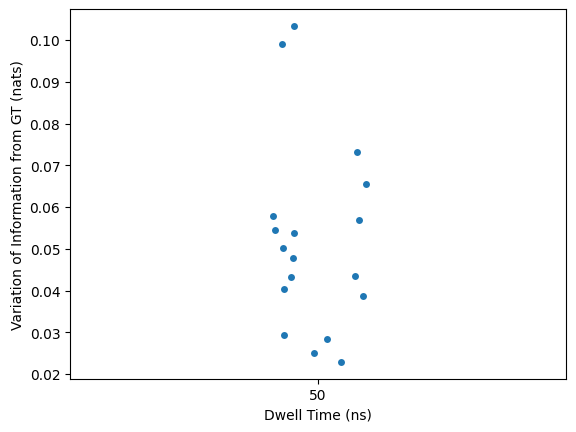

In [28]:
sns.stripplot(data=df, y="Variation of Information from GT (nats)", x="Dwell Time (ns)")

# Visualize result

In [21]:
images = {}

desired_dwts = [50] #[25, 50, 100, 400, 800, 1200]

with h5py.File(data_path, "r") as f:
    reg = list(f.keys())[2]
    group = f[reg]

    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]
    
    gt_mask = group[f"{slowest_dwt}/mask"][()]
    gt_mask_dilated = ndi.binary_dilation(gt_mask, iterations=10)
    gt_mask_masked = np.ma.masked_where(gt_mask_dilated == 0, gt_mask_dilated)
    frac_rescan = np.sum(gt_mask > 0) / gt_mask.size

    for dwt in desired_dwts:
        im = group[f"{dwt}/im"][()]

        mask, probs = get_prediction(im, model)
        pctile = np.percentile(probs.flatten(), (1-frac_rescan)*100)
        mask = probs > pctile
        mask_dilated = ndi.binary_dilation(mask, iterations=10)

        mask_masked = np.ma.masked_where(mask_dilated == 0, mask_dilated)

        voi,_,_ = pyvoi.VI(gt_mask.flatten(), mask.flatten())
        title_stem = f"Base_Dwell_Time:_{dwt}ns_VOI_{voi.item():.2f}"

        print(f"{probs.shape} {probs.dtype} {np.amin(probs)}-{np.median(probs)}-{np.amax(probs)}")
        images[title_stem + "_image"] = im
        images[title_stem + "_label"] = mask_masked
        images[title_stem + "_pred"] = mask


images["ground_truth_image"] = im
images["ground_truth_label"] = gt_mask_masked
images["ground_truth_pred"] = gt_mask
images["high_dwell_time_image"] = im


(1632, 1920) float32 0.0-0.0-0.9970884919166565


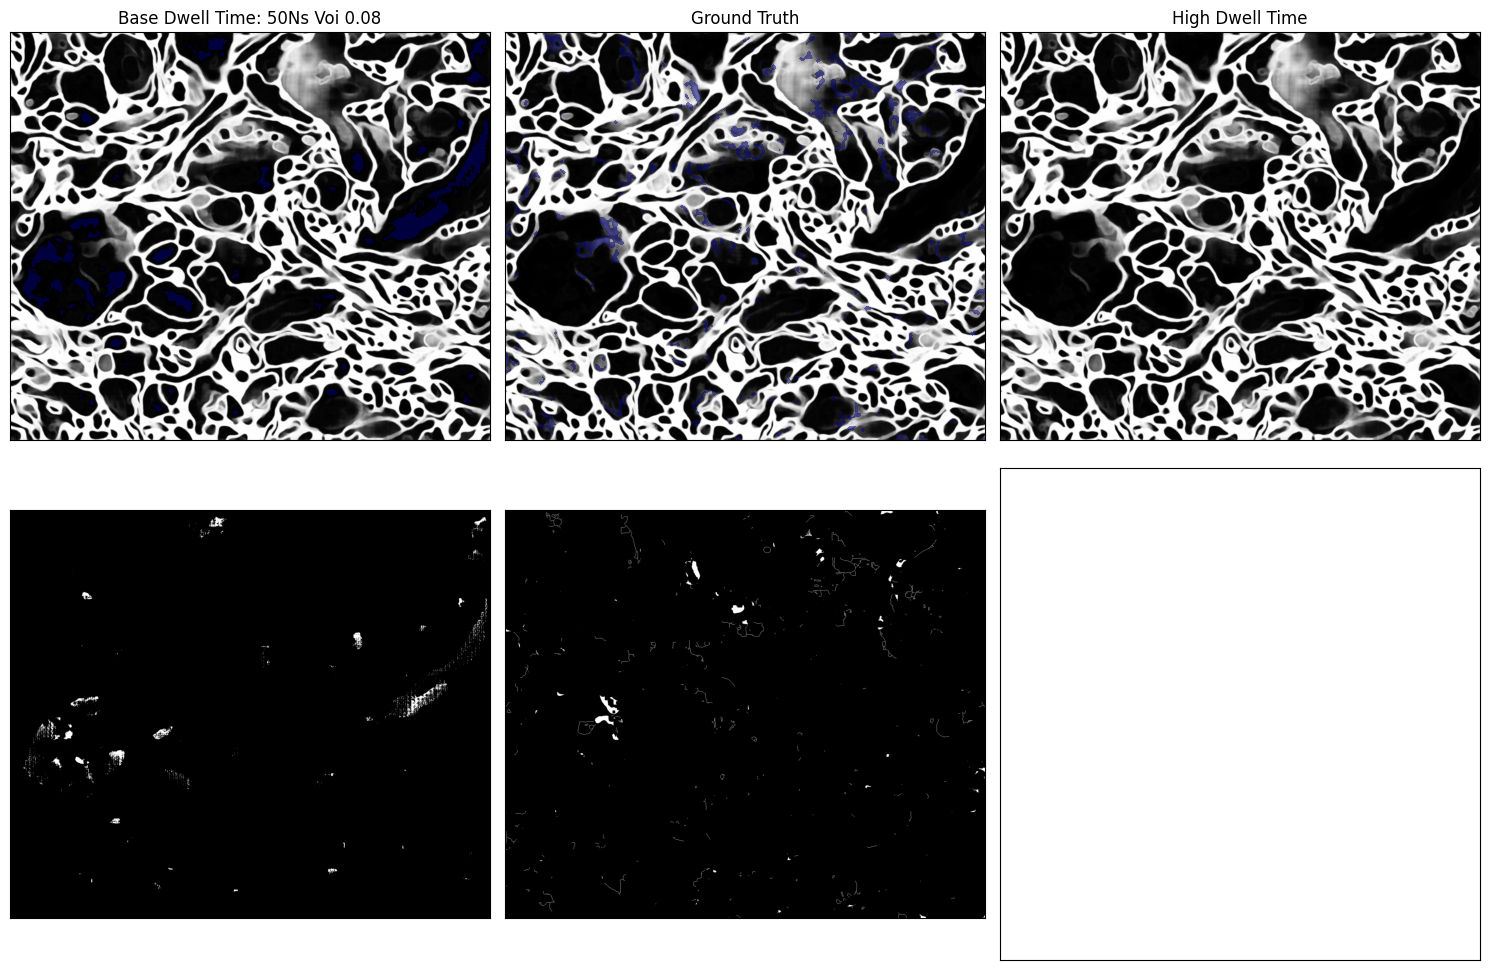

In [22]:
utils.visualize(**images)